# 用训练好的 keras 模型预测

data: https://www.kaggle.com/datasets/sagnikseal/household-power-consumption

In [1]:
DIRECTORY='./data/'
FILE_NAME='Household_power_consumption.csv'
KERAS_MODEL_FILE_NAME='keras_model.h5'
BATCH_SIZE=32
NUM_STEPS=60
NUM_PREDICT=165

In [2]:
import math
import random
import datetime
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.metrics
import matplotlib.pyplot as plt
from tensorflow import keras

import power_util

## 1. 数据预处理

In [3]:
# 数据导入
file_path = power_util.gen_abspath(DIRECTORY, FILE_NAME)
date_parser = lambda e: datetime.datetime.strptime(e, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(file_path,
                 header=0,
                 sep=',',
                 index_col='datetime',
                 on_bad_lines='warn',
                 parse_dates=['datetime'],
                 date_format='%Y-%m-%d %H:%M:%S',
                 encoding='utf-8')

# 特征缩放
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(df)

In [4]:
# 随机采样策略
def seq_data_iter(corpus, num_steps, use_random):
    # 随机偏移
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 子序列的数量，-1 是给 y label 挪空间
    num_subseqs = (len(corpus) - 1) // num_steps
    # 子序列起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    if use_random:
        random.shuffle(initial_indices)

    # 输入起始索引，返回整个序列
    def data(pos):
        return corpus[pos:pos+num_steps]

    X = np.array([data(i) for i in initial_indices])
    Y = np.array([corpus[i+num_steps] for i in initial_indices])

    return X, Y

# 分割训练集和测试集
def train_test_split(data, test_size, num_steps, use_random):
    index = math.floor(len(data) * (1-test_size))
    print(f'index: {index}')

    train = data[:index,]
    test = data[index:,]

    X_train, y_train = seq_data_iter(corpus=train,
                     num_steps=num_steps,
                     use_random=use_random)
    X_test, y_test = seq_data_iter(corpus=test,
                         num_steps=num_steps,
                         use_random=use_random)

    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data=data,
                                                    test_size=0.01,
                                                    num_steps=NUM_STEPS,
                                                    use_random=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

index: 2054506


((34240, 60, 8), (345, 60, 8), (34240, 8), (345, 8))

## 2. 用训练好的 keras 模型预测

In [6]:
# 加载 keras 模型
keras_model_path = power_util.gen_abspath(DIRECTORY, KERAS_MODEL_FILE_NAME)
model = keras.models.load_model(keras_model_path)

2024-05-11 11:14:12.567143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# 预测
def predict(x, y_true):
    y_pred = model.predict(x)
    y_pred = scaler.inverse_transform(y_pred)
    y_true = scaler.inverse_transform(y_true)

    return y_pred, y_true

In [8]:
# 基于之前的预测序列往下预测
def predict_sequence(data_slice, num_steps, verbose=1):
    assert len(data_slice) > num_steps, 'len(data_slice) should greater than num_steps'
    feture_num = data_slice.shape[1]
    num_predict = len(data_slice) - num_steps

    # 取第一个num_steps长序列
    pred_list = []
    seq = data_slice[:num_steps]
    for i in range(num_predict):
        seq_reshape = seq.reshape(-1,num_steps,feture_num)
        next_elem = model.predict(seq_reshape, verbose=verbose)
        pred_list.append(next_elem)
        seq = np.concatenate((seq[1:], next_elem))

    return np.array(pred_list).reshape(-1,feture_num)

# 计算 MSE
def calc_mse(y_true, y_pred):
    feture_num = y_true.shape[1]
    res = []
    for i in range(feture_num):
        mse = sklearn.metrics.mean_squared_error(y_true[:,i], y_pred[:,i])
        res.append(mse)
    return pd.DataFrame({'mse': res}, index=df.columns)

# 真实值与预测值可视化
def visualization(y_true, y_pred, topn=200):
    feture_num = y_true.shape[1]

    plt.figure(figsize=(15, 30))
    for i, col in zip(range(feture_num), df.columns):
        plt.subplot(feture_num, 2, i+1)
        plt.plot(y_pred[:topn,i], color='red', alpha=0.7, label='y_pred')
        plt.plot(y_true[:topn,i], color='blue', alpha=0.5, label='y_true')
        plt.title(col)
        plt.legend()
        plt.grid(visible=True, axis='y')
    plt.show()

def predict_sequence_wrap(data, start, num_predict, num_steps):
    feture_num = data.shape[1]
    data_size = num_steps + num_predict
    dt = data[start:start+data_size]
    y_true = dt[num_steps:]
    y_pred = predict_sequence(data_slice=dt,
                              num_steps=num_steps,
                              verbose=0)

    y_pred = scaler.inverse_transform(y_pred)
    y_true = scaler.inverse_transform(y_true)
    dt = scaler.inverse_transform(dt)

    s_pred = np.concatenate((np.array([[None for _ in range(feture_num)] for _ in range(num_steps)]), y_pred))
    visualization(y_true=dt, y_pred=s_pred)

    return y_true, y_pred

## 3. keras: 预测下一个值

基于前 num_steps 个值，预测下一个值

6/6 [==============================] - 1s 10ms/step


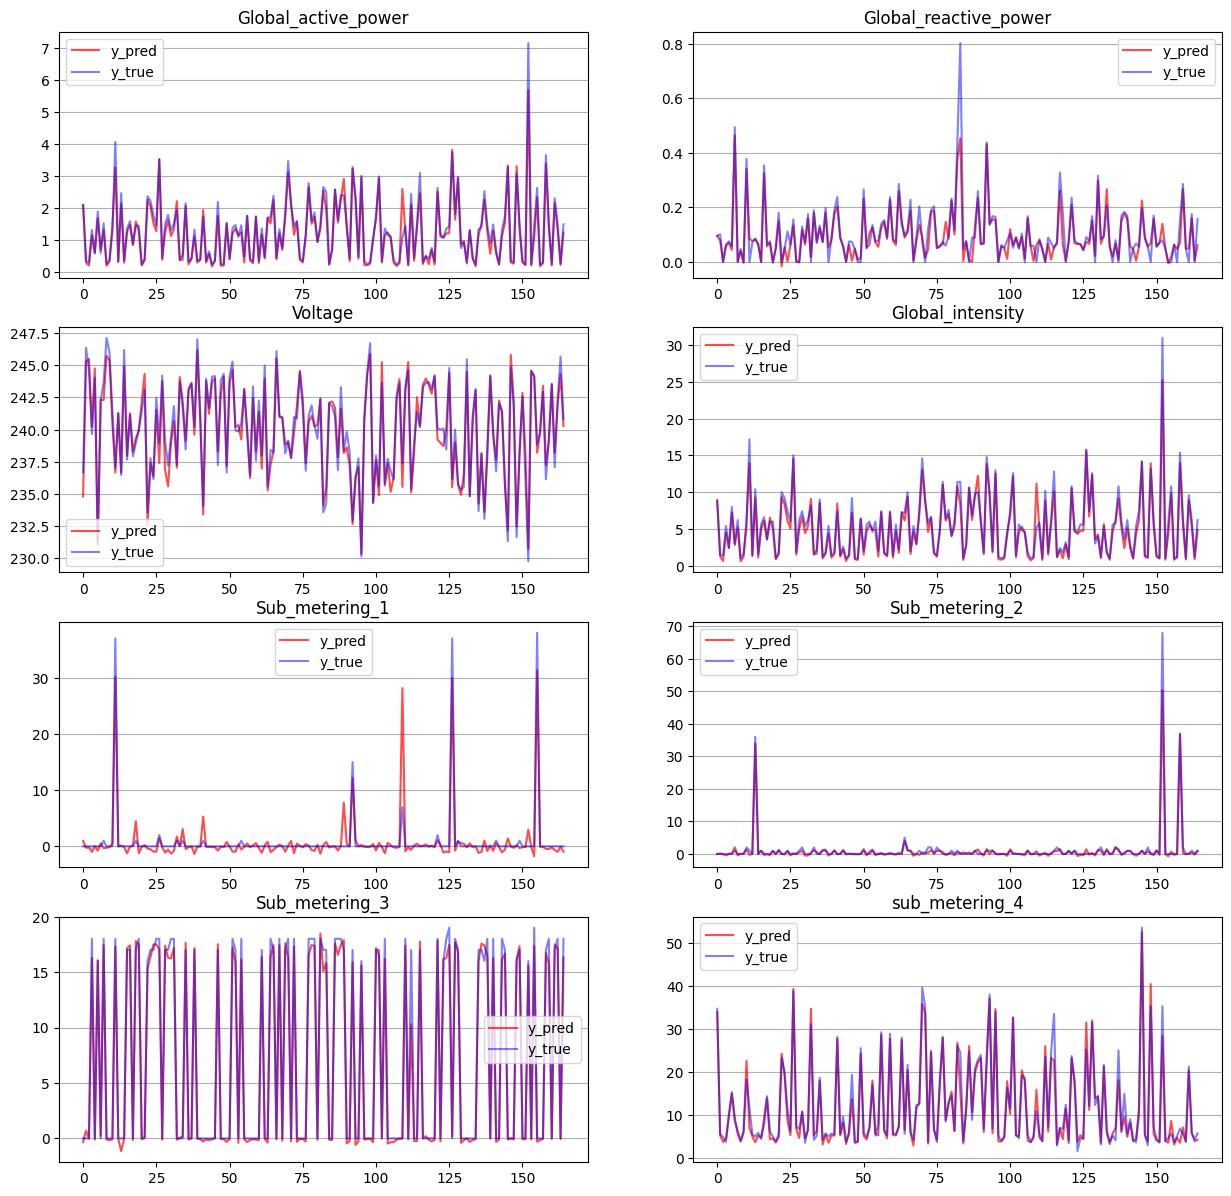

In [9]:
y_pred, y_true = predict(X_test[:NUM_PREDICT], y_test[:NUM_PREDICT])
visualization(y_true=y_true, y_pred=y_pred)

In [10]:
calc_mse(y_true=y_true, y_pred=y_pred)

,mse
Global_active_power,0.055569
Global_reactive_power,0.001710
Voltage,0.599893
Global_intensity,1.029582
Sub_metering_1,4.622693
Sub_metering_2,2.138720
Sub_metering_3,0.742484
sub_metering_4,4.103606


## 4. keras: 预测整个序列

基于前 num_steps 个值，预测后面整个序列

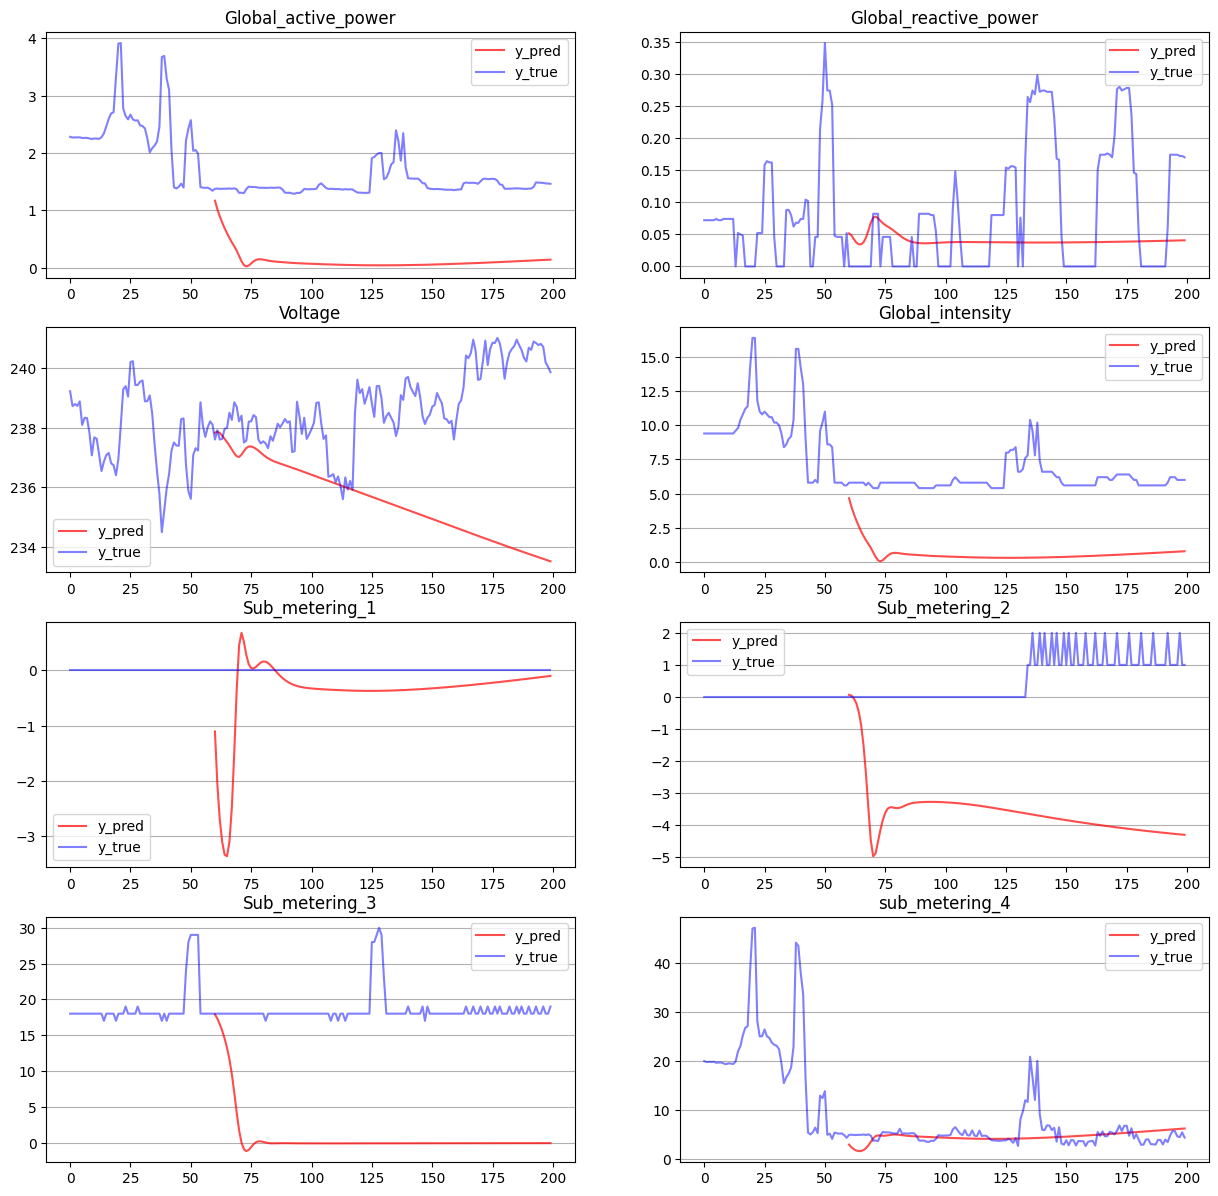

In [11]:
y_true, y_pred = predict_sequence_wrap(data=data,
                      start=2001000,
                      num_predict=NUM_PREDICT,
                      num_steps=NUM_STEPS)

In [12]:
calc_mse(y_true=y_true, y_pred=y_pred)

,mse
Global_active_power,1.617260
Global_reactive_power,0.010766
Voltage,21.559384
Global_intensity,26.923634
Sub_metering_1,0.449420
Sub_metering_2,19.397348
Sub_metering_3,286.159011
sub_metering_4,7.660282


我们发现，基于已预测数据继续向下预测，产生的数据偏移巨大。

为什么？

数据本身难以预测。且输入特征不够，比如像小时数这样的周期性特征并没有用于训练，学好不周期关系是正常的。

如何解决？

重新设计输入输出；调整超参；对于周期数据，时间步可能是一个重要参数